In [1]:
import importlib.resources as pkg_resources
from typing import Optional

import pandas as pd
import numpy as np
import plotly.graph_objects as go

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

import deep_paint

## Multiclass Classifier

In [2]:
# Load embeddings
multiclass_embeddings_path = pkg_resources.files(deep_paint).joinpath("..", "results", "embeddings", "multiclass_rxrx2.csv").resolve()
multiclass_embeddings_combined = pd.read_csv(multiclass_embeddings_path)

In [3]:
def split_embeddings(embeddings_df: pd.DataFrame) -> tuple:
    logits_cols = [col for col in embeddings_df.columns if col.isdigit()]
    embeddings = embeddings_df[logits_cols + ["index"]]
    metadata = embeddings_df[embeddings_df.columns.difference(logits_cols)]
    return embeddings, metadata

def plot_pca_density(
    combined_embeddings: pd.DataFrame,
    pc_col: str,
    label_col: str,
    color_map: dict,
    ticks: dict,
    label_map: Optional[dict] = None,
    renderer: str = "notebook"
    ):
    """
    Plot density plots of embeddings using PCA.
    
    Parameters
    ----------
    combined_embeddings: pd.DataFrame
        DataFrame of combined embeddings and metadata
    pc_col: str
        Name of principal component to plot
    label_col: str
        Column in DataFrame that contains labels
    color_map: dict
        Dictionary that maps labels to colors
    ticks: dict
        Dictionary of tick values.
        Ex. {"xaxis": {"vals": [0, 10, 20], "dtick": 10}}, {"yaxis": {"vals": [0, 10, 20], "dtick": 10}}
    label_map: dict, optional
        Dictionary that maps label names (to display on legend)
    renderer: str, default notebook
        Plotly renderer
    """
    # Split combined embeddings
    embeddings, metadata = split_embeddings(combined_embeddings)

    # Mean center embeddings
    embeddings = embeddings - embeddings.mean()

    # Scale to unit variance
    x = StandardScaler().fit_transform(embeddings)
    x = pd.DataFrame(x, columns=embeddings.columns)

    # Principal component analysis
    pca_model = PCA(n_components=2)
    pca = pca_model.fit_transform(x)
    pca_df = pd.DataFrame(pca, columns=["PC 1", "PC 2"])
    pca_df = pd.concat([pca_df, metadata], axis=1) # merge with metadata

    # Define lower and upper percentile limits
    lower_limit = 1
    upper_limit = 99

    # Calculate lower and upper limits
    lower_pc1 = np.percentile(pca_df["PC 1"], lower_limit)
    upper_pc1 = np.percentile(pca_df["PC 1"], upper_limit)

    lower_pc2 = np.percentile(pca_df["PC 2"], lower_limit)
    upper_pc2 = np.percentile(pca_df["PC 2"], upper_limit)

    # Filter out extreme values in PC1 and PC2
    pca_df = pca_df[(pca_df["PC 1"] > lower_pc1) & (pca_df["PC 1"] < upper_pc1)]
    pca_df = pca_df[(pca_df["PC 2"] > lower_pc2) & (pca_df["PC 2"] < upper_pc2)]
    pca_df.reset_index(inplace=True, drop=True)

    # Violin Plot
    fig = go.Figure()
    labels = pd.unique(pca_df[label_col])
    pc_idx = 0 if pc_col == "PC 1" else 1
    for label in labels:
        label_slice = pca_df[pca_df[label_col] == label][pc_col]
        kde = gaussian_kde(label_slice, bw_method=2)
        x_range = np.linspace(-40, 80, 1000)
        y_range = kde.evaluate(x_range)
        fig.add_trace(
            go.Scatter(
                x=x_range,
                y=y_range,
                mode='lines',
                name=label,
                line=dict(color=color_map[label])
            )
        )
    
    fig.update_layout(
        xaxis=dict(
            title=f"{pc_col} ({str(repr(round(pca_model.explained_variance_ratio_[pc_idx].item() * 100, 1)))}%)",
            title_standoff=25,
            gridcolor="#E6E6E6",
            gridwidth=1,
            zerolinecolor="#E6E6E6",
            showticklabels=True,
            tickmode="array",
            tickvals=ticks["xaxis"]["vals"],
            showline=True,
            linewidth=1,
            linecolor='black',
            mirror=True,
            minor=dict(
                tickmode="linear",
                tick0=0,
                dtick=ticks["xaxis"]["dtick"],
                tickcolor="black",
                ticklen=5,
                gridcolor="#E6E6E6",
                gridwidth=1
            )
        ),
        yaxis=dict(
            title="Density",
            title_standoff=25,
            gridcolor="#E6E6E6",
            gridwidth=1,
            zerolinecolor="#E6E6E6",
            showticklabels=True,
            showline=True,
            linewidth=1,
            linecolor='black',
            mirror=True,
        ),
        showlegend=False,
        font=dict(
            family="Arial, sans-serif",
            size=18,
            color="black"
        ),
        plot_bgcolor='white',
    )
    fig.show(renderer=renderer)

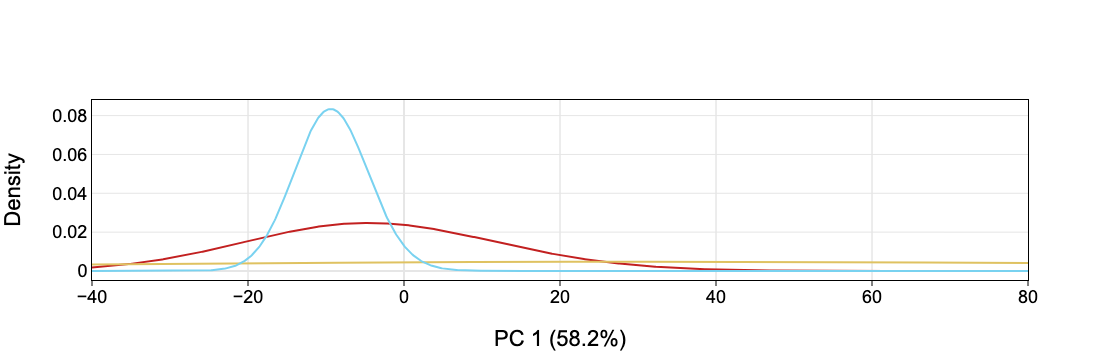

In [4]:
color_map = {
    'Cytokine-GF': '#c22020',
    'Toxin': '#dfc261',
    'Untreated': '#79d2f0'
}

plot_pca_density(
    multiclass_embeddings_combined,
    pc_col="PC 1",
    label_col="class",
    color_map=color_map,
    ticks={
        "xaxis": {
            "vals": [-40, -20, 0, 20, 40, 60, 80],
            "dtick": 20
        }
    },
    renderer="jupyterlab"
)

In [5]:
color_map = {
    'Cytokine-GF': '#c22020',
    'Toxin': '#dfc261',
    'Untreated': '#79d2f0'
}

plot_pca_density(
    multiclass_embeddings_combined,
    pc_col="PC 2",
    label_col="class",
    color_map=color_map,
    ticks={
        "xaxis": {
            "vals": [-40, -20, 0, 20, 40, 60, 80],
            "dtick": 20
        }
    },
    renderer="jupyterlab"
)